In [49]:
import pandas as pd
import numpy as np
import sklearn
import matt_acquire
import matt_prepare
import pandas as pd
import numpy as np
import sklearn
import matt_acquire
from matt_acquire import get_zillow_data
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from matt_acquire import get_zillow_data
from matt_prepare import prep_zillow_data


In [3]:
# Pull in our data both scaled and unscaled

In [4]:
def prep_zillow_data(target):
    df = get_zillow_data()
    df = df[['calculatedfinishedsquarefeet', 'bedroomcnt', 'bathroomcnt', 'lotsizesquarefeet', 'taxvaluedollarcnt']]
    df.dropna(inplace=True)

    train_validate, test = train_test_split(df, test_size=.2, random_state=123)

    train, validate = train_test_split(train_validate, test_size=.3, random_state=123)

    X_train = train.drop(columns=[target])
    y_train = train[target]
    
    X_validate = validate.drop(columns=[target])
    y_validate = validate[target]
    
    X_test = test.drop(columns=[target])
    y_test = test[target]
    
    scaler = sklearn.preprocessing.MinMaxScaler()

    scaler.fit(X_train)

    X_train_scaled = pd.DataFrame(scaler.transform(X_train))
    X_validate_scaled = pd.DataFrame(scaler.transform(X_validate))
    X_test_scaled = pd.DataFrame(scaler.transform(X_test))

    X_train_scaled.rename(columns={0: 'Unit_Sq_ft', 1: 'Bedroom_Count', 2: 'Bathroom_Count', 3: 'lotsizesquarefeet' }, inplace=True)
    X_validate_scaled.rename(columns={0: 'Unit_Sq_ft', 1: 'Bedroom_Count', 2: 'Bathroom_Count', 3: 'lotsizesquarefeet'}, inplace=True)
    X_test_scaled.rename(columns={0: 'Unit_Sq_ft', 1: 'Bedroom_Count', 2: 'Bathroom_Count', 3: 'lotsizesquarefeet'}, inplace=True)

    return train, y_train, y_validate, y_test, X_train_scaled, X_train, X_validate, X_test, X_validate_scaled, X_test_scaled

In [5]:
train, y_train, y_validate, y_test, X_train_scaled, X_train, X_validate, X_test, X_validate_scaled, X_test_scaled = prep_zillow_data('taxvaluedollarcnt')

In [6]:
# Hypothesis Test

In [7]:
alpha = .05

In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7266 entries, 6531 to 10999
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   calculatedfinishedsquarefeet  7266 non-null   float64
 1   bedroomcnt                    7266 non-null   float64
 2   bathroomcnt                   7266 non-null   float64
 3   lotsizesquarefeet             7266 non-null   float64
dtypes: float64(4)
memory usage: 283.8 KB


# Explore
We will explore our prepped data to identify drivers of house value and relationships between variables.
***

We begin by creating a heatmap of that includes each of the features we retained from our prep phase:
- unit_sq_ft (formerly calculatedfinishedsquarefeet) 
- bedroom_count (formerly bedroomcnt)                    
- bathroom_count (formerly bathroomcnt)
- lot_size_sq_ft (formerly lotsizesquarefeet) 

(0, 4)

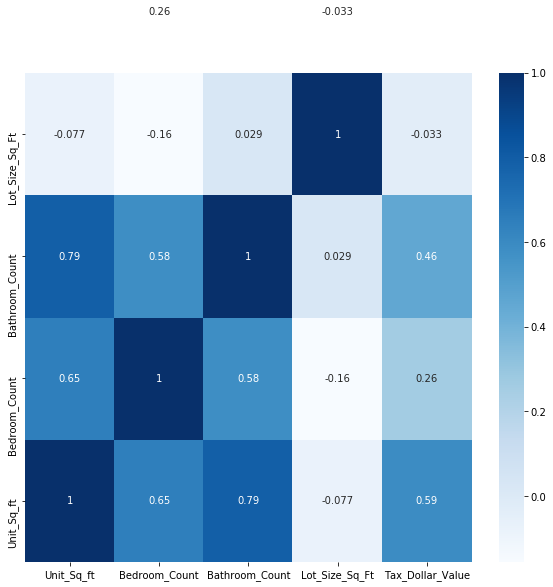

In [58]:
# creating copy of train DF to avoid altering the original
hmap_train = train.copy()

# creating scaler object
scaler = sklearn.preprocessing.MinMaxScaler()

# fitting scaler to train data
scaler.fit(hmap_train)

# scaling train data and converting to data frame
hmap_train = pd.DataFrame(scaler.transform(hmap_train))

# renaming columns as they were erased in the DF conversion
hmap_train.rename(columns={0: 'Unit_Sq_ft', 1: 'Bedroom_Count', 2: 'Bathroom_Count', 3: 'Lot_Size_Sq_Ft', 4: 'Tax_Dollar_Value' }, inplace=True)

# plotting heatmap
plt.figure(figsize=(10,9))
sns.heatmap(hmap_train.corr(), cmap='Blues', annot=True)
plt.ylim(0, 4)

Given their strong tones and coefficients, bathroom_count, bedroom_count and unit_sq_ft all appear to be strong drivers of house value.

Given it's weak coloring an low coefficient, lot_size_sq_feet appears to be a weak drivr of house value.

We will create hypothesis tests and visualizations to further explore each of these features in more depth.

### Feature: calculatedfinishedsquarefeet

### Initial idea: The value of a house is impacted by how large its size. 

### Test: Pearson Correlation

Ho = There is no linear correlation between calculated finished square feet and home value.

H1 = There is a linear correlation between calculated finished square feet and home value.

In [36]:
x = X_train['calculatedfinishedsquarefeet']
y = y_train
r, p = stats.pearsonr(x, y)

print(f'alpha = .05\n')
print(f'r = {r:.5f}')
print(f'p = {p:.3f}')

alpha = .05

r = 0.59134
p = 0.000


- Since p is less than alpha, we reject our null hypothesis that there is no linear relationship between calculated finished square feet and home value.

- In other words, there is evidence that the size of a house has an impact on the house's value.

### Feature: lotsizesquarefeet

### Initial idea: The value of a house is impacted by how the size of the lot it is located on. 

### Test: Pearson Correlation

Ho = There is no linear correlation between lot size and home value.

H1 = There is a linear correlation between lot size and home value.

In [37]:
x = X_train['lotsizesquarefeet']
y = y_train
r, p = stats.pearsonr(x, y)

print(f'alpha = .05\n')
print(f'r = {r:.5f}')
print(f'p = {p:.3f}')

alpha = .05

r = -0.03342
p = 0.004


- Since p is less than alpha, we reject our null hypothesis that there is no linear correlation between bathroom count and home value.

- In other words, there is evidence that the size of the lot a house is located on has an impact on the house's value.

# T-Test

### Feature: bathroom_count 

### Initial idea: The value of a unit will increase if it has more than the average number of bathrooms. We will calculate the average number of bathrooms per house and then formulate a hypothesis using this data.

### Test: T-Test

In [40]:
# calculating average number of bathrooms per house
avg_bathroom_count = round((train.bathroomcnt).mean())

print(f'The average number of bathrooms in a house is {avg_bathroom_count}.\n')
print(f'We will formulate our hypothesis on the grounds that a house has more than the average number of bathrooms if it has 3 or more')

The average number of bathrooms in a house is 2.

We will formulate our hypothesis on the grounds that a house has more than the average number of bathrooms if it has 3 or more


H0 - The value of units with 3 or more bathrooms is equal to or less than the value of units with 2 or less bathrooms

H1 - The value of units with 3 or more bathrooms is greater than the value of units with 2 or less bathrooms.

In [41]:
x1 = train[train.bathroomcnt > 2].taxvaluedollarcnt
x2 = train[train.bathroomcnt <= 2].taxvaluedollarcnt

In [42]:
t, p = stats.ttest_ind(x1, x2)
print(f'alpha = .05\n')
print(f't = {t:.5f}')
print (f'p = {p / 2}')

alpha = .05

t = 25.07040
p = 2.0955693980555035e-133


- Since p is less than alpha and t is greater than 0, we reject our null hypothesis that the value of units with 3 or more bathrooms is equal to or less than the value of units with 2 or less bathrooms.

- In other words, there is evidence that bathroom_count is a positive driver of house value.

### Feature: bedroom_count

### Initial idea: The value of a unit will increase if it has more than the average number of bedrooms. We will calculate the average number of bedrooms per house and then formulate a hypothesis using this data.

### Test: T-Test

In [30]:
# calculating average number of bedrooms per house
avg_bedroom_count = round((train.bedroomcnt).mean())

print(f'The average number of bedrooms in a house is {avg_bedroom_count}.\n')
print(f'We will formulate our hypothesis on the grounds that a house has more than the average number of bedrooms if it has 3 or more')

The average number of bedrooms in a house is 3.

We will formulate our hypothesis on the grounds that a house has more than the average number of bedrooms if it has 3 or more


H0 - The value of units with 3 or more bedrooms is equal to or less than the value of units with 2 or less bedrooms. 

H1 - The value of units with 3 or more bedrooms is greater than the value of units with less 2 or less bedrooms.

In [31]:
x1 = train[train.bedroomcnt > 2].taxvaluedollarcnt
x2 = train[train.bedroomcnt <= 2].taxvaluedollarcnt

In [39]:
t, p = stats.ttest_ind(x1, x2)
print(f'alpha = .05\n')
print(f't = {t:.5f}')
print (f'p = {p / 2}')

alpha = .05

t = 10.06640
p = 5.5569806575727444e-24


- Since p is less than alpha and t is greater than 0, we reject our null hypothesis that the value of units with 3 or more bedrooms is equal to or less than the value of units with 2 or less bedrooms.

- In other words, there is evidence that bedroom_count is a positive driver of house value.

### Exploration Takeaways

- Heatmap of all features shows bathroom_count, bedroom_count and unit_sq_ft are strong drivers of house value

- T-Tests suggest that having more than the average number of bathrooms or bedrooms in a house increases its value

- Pearson Correlation tests suggest that the size of a house and the lot it's located on have an impact on its value